# Notebook focused on COMET 

In [1]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
import os
import unittest
from datasets import load_dataset
import pickle
import matplotlib.pyplot as plt
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
    ...
    Methods
    -------
    parse_txt(path)
        Parses a txt file and returns a list of strings
    fix_format(sentence)
        Fixes the formatting of a sentence
    save_as_txt(path)
        Saves the data as a txt file
    save_as_csv(path)
        Saves the data as a csv file
    save_as_docx(path)
        Saves the data as a docx file
    get_data()
        Returns the data
    create_deepcopy()
        Returns a deepcopy of the DataLoader instance
    get_name()
        Returns the dataset name
    get_number_of_sentences()
        Returns the number of sentences in the data
    get_number_of_words()
        Returns the number of words in the data
    get_number_of_letters()
        Returns the number of letters in the data
    edit_distance(reference_sentence, sentence)
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
    get_edit_distance(reference, manual_wer=False)
        Returns the number of edits required to transform data into reference at word level, substitutions, insertions and deletions the associated dictionaries
        and the WER (withouth alignment) if manual_wer is set to True
    get_individual_edit_distance(reference)
        Returns the number of edits required to transform data into reference at word level for each individual sentence
    combine_nested_dict(dict1, dict2)
        Combines two nested dictionaries
    combine_dicts(dict1, dict2)
        Combines two dictionaries
    get_bleue_score(reference)
        Returns bleu score of the data against a reference
    get_wer(reference)
        Returns the Word Error Rate (WER) of the data against a reference. With word alignment
    get_bert_score(reference)
        Returns the BERT Score similarity score of the data against a reference
    get_LaBSE(reference, model=None, tokenizer=None)
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
    ...

    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])

    def edit_distance(reference_sentence, sentence):
        """
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
        """
        substitutions = 0
        insertions = 0
        deletions = 0
        substitution_dict = {}
        insertion_dict = {}
        deletion_dict = {}
        #remove punctuation and split into words
        sentence = re.sub(r'[^\w\s]','',sentence).lower().split()
        reference_sentence = re.sub(r'[^\w\s]','',reference_sentence).lower().split()
        #create matrix
        matrix = np.zeros((len(reference_sentence)+1,len(sentence)+1))
        #fill in first row and column
        for i in range(len(reference_sentence)+1):
            matrix[i][0] = i
        for j in range(len(sentence)+1):
            matrix[0][j] = j
        #fill in rest of matrix
        for i in range(1,len(reference_sentence)+1):
            for j in range(1,len(sentence)+1):
                if sentence[j-1] == reference_sentence[i-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(matrix[i-1][j-1], matrix[i-1][j], matrix[i][j-1])+1
        #backtrack to find edits
        i = len(reference_sentence)
        j = len(sentence)
        while i > 0 and j > 0:
            if sentence[j-1] == reference_sentence[i-1]:
                i -= 1
                j -= 1
            else:
                if matrix[i][j] == matrix[i-1][j-1]+1:
                    substitutions += 1
                    if reference_sentence[i-1] not in substitution_dict:
                        substitution_dict[reference_sentence[i-1]] = {sentence[j-1]:1}
                    else:
                        if sentence[j-1] not in substitution_dict[reference_sentence[i-1]]:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] = 1
                        else:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] += 1
                    i -= 1
                    j -= 1
                elif matrix[i][j] == matrix[i-1][j]+1:
                    deletions += 1
                    if reference_sentence[i-1] not in deletion_dict:
                        deletion_dict[reference_sentence[i-1]] = 1
                    else:
                        deletion_dict[reference_sentence[i-1]] += 1
                    i -= 1
                elif matrix[i][j] == matrix[i][j-1]+1:
                    insertions += 1
                    if sentence[j-1] not in insertion_dict:
                        insertion_dict[sentence[j-1]] = 1
                    else:
                        insertion_dict[sentence[j-1]] += 1
                    j -= 1
        while i > 0:
            deletions += 1
            if reference_sentence[i-1] not in deletion_dict:
                deletion_dict[reference_sentence[i-1]] = 1
            else:
                deletion_dict[reference_sentence[i-1]] += 1
            i -= 1
        while j > 0:
            insertions += 1
            if sentence[j-1] not in insertion_dict:
                insertion_dict[sentence[j-1]] = 1
            else:
                insertion_dict[sentence[j-1]] += 1
            j -= 1
        distance = substitutions+insertions+deletions
        return substitutions, insertions, deletions, substitution_dict, insertion_dict, deletion_dict, distance
        
    def get_edit_distance(self, reference, manual_wer=False):
        """
        Returns the number of edits required to transform data into reference at word level, substitutions, insertions and deletions the associated dictionaries
        and the WER (withouth alignment) if manual_wer is set to True
        """
        if type(reference) == list:
            substitutions = 0
            insertions = 0
            deletions = 0
            all_sub = {}
            all_ins = {}
            all_del = {}
            distance = 0
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, dist = DataLoader.edit_distance(reference[i], self.data[i], )
                all_sub = self.combine_nested_dict(all_sub, substitution_dict)
                all_ins = self.combine_dicts(all_ins, insertion_dict)
                all_del = self.combine_dicts(all_del, deletion_dict)
                substitutions += sub
                insertions += ins
                deletions += dele
                distance += dist
            if manual_wer:
                return substitutions, insertions, deletions, all_sub, all_ins, all_del, distance, distance/(sum([len(sentence.split()) for sentence in reference]))
            return substitutions, insertions, deletions, all_sub, all_ins, all_del, distance
        elif type(reference) == DataLoader:
            return self.get_edit_distance(reference.get_data(), manual_wer=manual_wer)
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_individual_edit_distance(self, reference):
        """
        Returns the number of edits required to transform data into reference at word level for each individual sentence
        """
        if type(reference) == list:
            output = []
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, distance = DataLoader.edit_distance(reference[i], self.data[i], )
                output.append((sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, distance))
            return output
        elif type(reference) == DataLoader:
            return self.get_individual_edit_distance(reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")       

    def combine_nested_dict(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                for key2 in dict2[key]:
                    if key2 not in dict1[key]:
                        dict1[key][key2] = dict2[key][key2]
                    else:
                        dict1[key][key2] += dict2[key][key2]
        return dict1
    
    def combine_dicts(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                dict1[key] += dict2[key]
        return dict1

    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        """
        Returns the Word Error Rate (WER) of the data against a reference. With word alignment
        """
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")


    def get_bert_score(self, reference):
        """
        Returns the BERT Score similarity score of the data against a reference.
        """
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(), lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_LaBSE(self, reference, model=None, tokenizer=None):
        """
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
        """
        if model is None:
            model = BertModel.from_pretrained("setu4993/LaBSE")
        if tokenizer is None:
            tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
        if type(reference) == list:
            pass
        elif type(reference) == DataLoader:
            reference = reference.get_data()
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
        target = self.data
        reference_inputs = tokenizer(reference, return_tensors="pt", padding=True).to("cuda")
        target_inputs = tokenizer(target, return_tensors="pt", padding=True).to("cuda")
        with torch.no_grad():
            reference_outputs = model(**reference_inputs)
            target_outputs = model(**target_inputs)
        reference_embeddings = reference_outputs.pooler_output
        target_embeddings = target_outputs.pooler_output
        return self.similarity(reference_embeddings, target_embeddings)
    def get_bleurt(self, reference, scorer = None):
        """
        BLEURT-20 is required and can be downloaded via https://github.com/google-research/bleurt
        This is the most up to date version of BLEURT and is multilingual
        Returns the BLEURT similarity score of the data against a reference.
        """
        if scorer is None:
            try:
                scorer = score.BleurtScorer("BLEURT-20")
            except:
                raise Exception("BLEURT-20 not found")
        if type(reference) == list:
            scores = scorer.score(references = reference, candidates = self.data)
        elif type(reference) == DataLoader:
            scores = scorer.score(references = reference.get_data(), candidates = self.data)
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
        return scores
    def get_COMET(self, reference, source):
        """
        Returns the COMET similarity score of the data against a reference and a source.
        Source is the original sentence and reference is the translation
        """
        comet = evaluate.load("comet")
        if type(reference) == list:
            return comet.compute(predictions=self.data, references=reference, sources=source)
        elif type(reference) == DataLoader:
            return comet.compute(predictions=self.data, references=reference.get_data(), sources=source.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

loading data

In [2]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("output_data/v1/aws"):
    temp = DataLoader(path="output_data/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("output_data/v2/aws"):
    temp = DataLoader(path="output_data/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

azure_data_v1 = []
for filename in os.listdir("output_data/v1/azure"):
    temp = DataLoader(path="output_data/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("output_data/v2/azure"):
    temp = DataLoader(path="output_data/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("output_data/v1/google"):
    temp = DataLoader(path="output_data/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("output_data/v2/google"):
    temp = DataLoader(path="output_data/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("output_data/v1/gpt"):
    temp = DataLoader(path="output_data/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("output_data/v2/gpt"):
    temp = DataLoader(path="output_data/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)

# from datasets import load_dataset
# dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
to_translate_wmt14_en = []
reference_wmt14_fr = []

# for i in range(len(dataset_wmt_enfr)):
#     to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
#     reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(path="wmt14_fr.txt", dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(path="wmt14_en.txt", dataset_name="wmt14_en")


calculating BLEU and WER

In [3]:
aws_bleu_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V1 scores: {aws_bleu_scores_v1}")

aws_bleu_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V2 scores: {aws_bleu_scores_v2}")

google_bleu_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V1 scores: {google_bleu_scores_v1}")

google_bleu_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V2 scores: {google_bleu_scores_v2}")

azure_bleu_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU scores: {azure_bleu_scores_v1}")

azure_bleu_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU V2 scores: {azure_bleu_scores_v2}")

gpt_bleu_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V1 scores: {gpt_bleu_scores_v1}")

gpt_bleu_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V2 scores: {gpt_bleu_scores_v2}")
#same of above but for WER
aws_wer_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V1 scores: {aws_wer_scores_v1}")

aws_wer_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V2 scores: {aws_wer_scores_v2}")

google_wer_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V1 scores: {google_wer_scores_v1}")

google_wer_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V2 scores: {google_wer_scores_v2}")

azure_wer_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER scores: {azure_wer_scores_v1}")

azure_wer_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER V2 scores: {azure_wer_scores_v2}")

gpt_wer_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V1 scores: {gpt_wer_scores_v1}")

gpt_wer_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V2 scores: {gpt_wer_scores_v2}")

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt
AWS BLEU V1 scores: [{'bleu': 0.4561216039012071, 'precisions': [0.7113003696141021, 0.5157512605042017, 0.3915541108557978, 0.3013265858331749], 'brevity_penalty': 1.0, 'length_ratio': 1.0010090556274256, 'translation_length': 77378, 'reference_length': 77300}, {'bleu': 0.4228095535642235, 'precisions': [0.6854196746866336, 0.4826468243422801, 0.35838742267185186, 0.26955065265103384], 'brevity_penalty': 1.0, 'length_ratio': 1.012457956015524, 'translation_length': 78263, 'reference_length': 77300}, {'bl

Loading/Calculating COMET similarity score

In [4]:
aws_COMET_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_COMET_scores_v1.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"AWS COMET V1 scores: {aws_COMET_scores_v1}")

aws_COMET_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_COMET_scores_v2.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"AWS COMET V2 scores: {aws_COMET_scores_v2}")

google_COMET_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_COMET_scores_v1.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"Google COMET V1 scores: {google_COMET_scores_v1}")

google_COMET_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_COMET_scores_v2.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"Google COMET V2 scores: {google_COMET_scores_v2}")

azure_COMET_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_COMET_scores_v1.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"Azure COMET scores: {azure_COMET_scores_v1}")

azure_COMET_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_COMET_scores_v2.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"Azure COMET V2 scores: {azure_COMET_scores_v2}")

gpt_COMET_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_COMET_scores_v1.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"GPT COMET V1 scores: {gpt_COMET_scores_v1}")

gpt_COMET_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_COMET_scores_v2.append(data.get_COMET(reference_corpus_fr, reference_corpus_en))
print(f"GPT COMET V2 scores: {gpt_COMET_scores_v2}")
#load COMET scores from pkl file

# aws_COMET_scores_v1 = pickle.load(open("COMET_scores/aws_COMET_scores_v1.pkl", "rb"))
# aws_COMET_scores_v2 = pickle.load(open("COMET_scores/aws_COMET_scores_v2.pkl", "rb"))
# google_COMET_scores_v1 = pickle.load(open("COMET_scores/google_COMET_scores_v1.pkl", "rb"))
# google_COMET_scores_v2 = pickle.load(open("COMET_scores/google_COMET_scores_v2.pkl", "rb"))
# azure_COMET_scores_v1 = pickle.load(open("COMET_scores/azure_COMET_scores_v1.pkl", "rb"))
# azure_COMET_scores_v2 = pickle.load(open("COMET_scores/azure_COMET_scores_v2.pkl", "rb"))
# gpt_COMET_scores_v1 = pickle.load(open("COMET_scores/gpt_COMET_scores_v1.pkl", "rb"))
# gpt_COMET_scores_v2 = pickle.load(open("COMET_scores/gpt_COMET_scores_v2.pkl", "rb"))


aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

AWS COMET V1 scores: [{'mean_score': 0.8808589970871007, 'scores': [0.912492573261261, 0.9353569149971008, 0.8555049896240234, 0.9864641427993774, 0.776009202003479, 0.886810302734375, 0.7958009839057922, 0.8149663805961609, 0.6288804411888123, 0.8700059056282043, 0.7651825547218323, 0.9013789892196655, 0.7814459800720215, 0.9434053897857666, 0.8409309983253479, 0.9651573300361633, 0.9834320545196533, 0.8442126512527466, 0.9821522235870361, 0.7355257868766785, 0.9354122877120972, 0.8937253952026367, 0.9241724610328674, 0.9027523398399353, 0.9653727412223816, 0.8081048130989075, 0.8484862446784973, 0.8706344962120056, 0.9001317620277405, 0.8394522070884705, 0.8487534523010254, 0.7005386352539062, 0.9079685807228088, 0.9435064196586609, 0.8448086977005005, 0.9072281718254089, 0.773242712020874, 0.9379690289497375, 0.9441195726394653, 0.8664557933807373, 0.8548194766044617, 0.860077440738678, 0.9780060052871704, 0.7689682841300964, 0.9108652472496033, 0.9608884453773499, 0.861151993274688

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.35.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.35_p_letter_0.0_p_confusing_word_0.0.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0.7_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

aws_fr.wmt14_en_p_homophone_0_p_letter_0.025_p_confusing_word_0.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

AWS COMET V2 scores: [{'mean_score': 0.8501364522046976, 'scores': [0.912492573261261, 0.9191322326660156, 0.8431926965713501, 0.9864641427993774, 0.803347110748291, 0.8900665640830994, 0.83006352186203, 0.8222047686576843, 0.6288804411888123, 0.82319575548172, 0.7253299355506897, 0.8360073566436768, 0.84116530418396, 0.7907153964042664, 0.8050562739372253, 0.9651573300361633, 0.9125529527664185, 0.8442126512527466, 0.9821523427963257, 0.6120486259460449, 0.9354122877120972, 0.7671603560447693, 0.842469334602356, 0.8431249856948853, 0.65388023853302, 0.5483801960945129, 0.7719788551330566, 0.6836901903152466, 0.8773900866508484, 0.42901697754859924, 0.8398576974868774, 0.691941499710083, 0.909165620803833, 0.9435064196586609, 0.6160441040992737, 0.9072281718254089, 0.773242712020874, 0.813430666923523, 0.9441195726394653, 0.8460552096366882, 0.8548194766044617, 0.8650627732276917, 0.948822021484375, 0.7938175201416016, 0.7961829900741577, 0.9608884453773499, 0.8389995694160461, 0.89954

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.docx


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.docx


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Google COMET V1 scores: [{'mean_score': 0.8775926347954687, 'scores': [0.912492573261261, 0.9514989852905273, 0.8539256453514099, 0.9864641427993774, 0.815143883228302, 0.8954126238822937, 0.8302563428878784, 0.8200434446334839, 0.4478403627872467, 0.9005593061447144, 0.7172229886054993, 0.8689026832580566, 0.7379974126815796, 0.9351593852043152, 0.7702429890632629, 0.9651573300361633, 0.9834320545196533, 0.8435590267181396, 0.9821522235870361, 0.808725118637085, 0.9399876594543457, 0.8726966381072998, 0.9381580352783203, 0.8944162130355835, 0.9541809558868408, 0.9303379654884338, 0.8484862446784973, 0.8629636168479919, 0.8887502551078796, 0.8285441398620605, 0.8154778480529785, 0.7952351570129395, 0.9292486310005188, 0.9435064196586609, 0.8272932171821594, 0.850314199924469, 0.6493512392044067, 0.9338857531547546, 0.9441196322441101, 0.9801713228225708, 0.8548194766044617, 0.8750298023223877, 0.9780060052871704, 0.7880517244338989, 0.914999783039093, 0.9608884453773499, 0.898039579391

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.35.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.35_p_letter_0.0_p_confusing_word_0.0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0.7_p_letter_0.0_p_confusing_word_0.0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

google_wmt14_en_p_homophone_0_p_letter_0.025_p_confusing_word_0.docx


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Google COMET V2 scores: [{'mean_score': 0.8066779381030804, 'scores': [0.912492573261261, 0.9353569149971008, 0.8089748620986938, 0.9864641427993774, 0.7587864995002747, 0.693735659122467, 0.8042210936546326, 0.7231085896492004, 0.4478403627872467, 0.5555853843688965, 0.7135911583900452, 0.8689026832580566, 0.7771304249763489, 0.7118464708328247, 0.8280422687530518, 0.9651573300361633, 0.9350472688674927, 0.7775291204452515, 0.9821522235870361, 0.4235064685344696, 0.855700671672821, 0.8531855940818787, 0.8173937797546387, 0.869103193283081, 0.9541809558868408, 0.7235397696495056, 0.7697460651397705, 0.5820909142494202, 0.8745786547660828, 0.4269680678844452, 0.7930494546890259, 0.7952351570129395, 0.906083345413208, 0.9435063004493713, 0.505029559135437, 0.8915996551513672, 0.6493512392044067, 0.9338857531547546, 0.9552606344223022, 0.45752182602882385, 0.8548194766044617, 0.8698975443840027, 0.948822021484375, 0.7896332740783691, 0.789232075214386, 0.9608884453773499, 0.82073092460632

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Azure COMET scores: [{'mean_score': 0.8761462919758909, 'scores': [0.912492573261261, 0.935356855392456, 0.8491458296775818, 0.9864641427993774, 0.8289499878883362, 0.8916812539100647, 0.8302563428878784, 0.8108856081962585, 0.796821117401123, 0.8733843564987183, 0.6906312704086304, 0.8791459798812866, 0.7791967391967773, 0.9351593852043152, 0.8260141015052795, 0.9651573300361633, 0.9834320545196533, 0.8524326682090759, 0.9821522235870361, 0.7803779244422913, 0.9354122877120972, 0.8982507586479187, 0.9393303990364075, 0.9101375341415405, 0.9425186514854431, 0.7232555150985718, 0.8482975959777832, 0.861836314201355, 0.9295801520347595, 0.8806290626525879, 0.7932446002960205, 0.8279883861541748, 0.9141285419464111, 0.9435063004493713, 0.840721845626831, 0.8915996551513672, 0.6471842527389526, 0.9338857531547546, 0.9441196322441101, 0.7514912486076355, 0.8548194766044617, 0.8731611967086792, 0.9780060052871704, 0.8399083018302917, 0.9095496535301208, 0.9608884453773499, 0.8643086552619934

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.35.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.35_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0.7_p_letter_0.0_p_confusing_word_0.0.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

azure_wmt14_en_p_homophone_0_p_letter_0.025_p_confusing_word_0.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Azure COMET V2 scores: [{'mean_score': 0.709788857133953, 'scores': [0.912492573261261, 0.9353569149971008, 0.8257678151130676, 0.9864641427993774, 0.6285658478736877, 0.6432763934135437, 0.7003620862960815, 0.6332163214683533, 0.796821117401123, 0.5574390292167664, 0.560676634311676, 0.6874748468399048, 0.5559301376342773, 0.7118464708328247, 0.7879615426063538, 0.9651573300361633, 0.9834320545196533, 0.770650327205658, 0.9821522235870361, 0.377699077129364, 0.7315117716789246, 0.8838372826576233, 0.7236490249633789, 0.609143853187561, 0.9425186514854431, 0.6095941662788391, 0.5980796813964844, 0.5522640943527222, 0.8165414929389954, 0.3505633771419525, 0.6124194264411926, 0.7952351570129395, 0.7877033352851868, 0.9399107694625854, 0.4535823464393616, 0.7920091152191162, 0.5729295015335083, 0.7241537570953369, 0.8351278901100159, 0.45752182602882385, 0.8548194766044617, 0.7362704277038574, 0.948822021484375, 0.39454761147499084, 0.7790114879608154, 0.9608884453773499, 0.63135278224945

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_confusing_letter_10.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_confusing_letter_20.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_confusing_word_10.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_confusing_word_20.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_homophone_10.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_homophone_20.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

GPT COMET V1 scores: [{'mean_score': 0.8776228979076103, 'scores': [0.9114145040512085, 0.935356855392456, 0.8311242461204529, 0.9864641427993774, 0.7924021482467651, 0.8821677565574646, 0.8218017220497131, 0.8407076597213745, 0.5593764185905457, 0.9048095941543579, 0.8028900027275085, 0.8808115124702454, 0.7932093739509583, 0.9624804258346558, 0.8291012644767761, 0.9651573300361633, 0.9834320545196533, 0.7886545062065125, 0.959666907787323, 0.8222699165344238, 0.9562540054321289, 0.9262040257453918, 0.9280804395675659, 0.9101375341415405, 0.9125893712043762, 0.8038804531097412, 0.8973171710968018, 0.855507493019104, 0.8953089714050293, 0.8621118068695068, 0.8028832674026489, 0.8450122475624084, 0.8895817995071411, 0.9435063004493713, 0.8329235911369324, 0.9124556183815002, 0.6471842527389526, 0.9338857531547546, 0.648246705532074, 0.4381197392940521, 0.8659480810165405, 0.8861111998558044, 0.9780060052871704, 0.8936446309089661, 0.90088951587677, 0.9608884453773499, 0.8418381214141846

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_confusing_letter_5.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_confusing_word_35.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_homophone_35.txt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

gpt_gpt_homophone_70.txt


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\gpric\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\gpric\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
c:\Users\gpric\anaconda3\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

GPT COMET V2 scores: [{'mean_score': 0.8701771210421334, 'scores': [0.9114145040512085, 0.9271910190582275, 0.8372644186019897, 0.9864641427993774, 0.7887662053108215, 0.8847683668136597, 0.8239814043045044, 0.8101920485496521, 0.5224162936210632, 0.8791333436965942, 0.8028900027275085, 0.9057223796844482, 0.7932093739509583, 0.9624804258346558, 0.8257423639297485, 0.9743772149085999, 0.9834320545196533, 0.7525387406349182, 0.959666907787323, 0.8222699165344238, 0.9562540054321289, 0.9262040257453918, 0.9223132729530334, 0.9101375341415405, 0.9125893712043762, 0.8038804531097412, 0.8875479102134705, 0.840137243270874, 0.9139251708984375, 0.8621118068695068, 0.7813048958778381, 0.8450122475624084, 0.9123589396476746, 0.9435063004493713, 0.8033136129379272, 0.9124556183815002, 0.6471842527389526, 0.9338857531547546, 0.648246705532074, 0.4381197392940521, 0.8659480810165405, 0.8296138644218445, 0.9780060052871704, 0.885101854801178, 0.90088951587677, 0.9608884453773499, 0.8418381214141846

In [5]:
# #save COMET scores to pickle files
import pickle
with open("COMET_scores/aws_COMET_scores_v1.pkl", "wb") as f:
    pickle.dump(aws_COMET_scores_v1, f)
with open("COMET_scores/aws_COMET_scores_v2.pkl", "wb") as f:
    pickle.dump(aws_COMET_scores_v2, f)
with open("COMET_scores/google_COMET_scores_v1.pkl", "wb") as f:
    pickle.dump(google_COMET_scores_v1, f)
with open("COMET_scores/google_COMET_scores_v2.pkl", "wb") as f:
    pickle.dump(google_COMET_scores_v2, f)
with open("COMET_scores/azure_COMET_scores_v1.pkl", "wb") as f:
    pickle.dump(azure_COMET_scores_v1, f)
with open("COMET_scores/azure_COMET_scores_v2.pkl", "wb") as f:
    pickle.dump(azure_COMET_scores_v2, f)
with open("COMET_scores/gpt_COMET_scores_v1.pkl", "wb") as f:
    pickle.dump(gpt_COMET_scores_v1, f)
with open("COMET_scores/gpt_COMET_scores_v2.pkl", "wb") as f:
    pickle.dump(gpt_COMET_scores_v2, f)


In [ ]:
print(aws_COMET_scores_v1)

[{'precision': [0.9149807691574097, 0.9491774439811707, 0.869432806968689, 1.0, 0.905444860458374, 0.9179094433784485, 0.8039261102676392, 0.8635247945785522, 0.8443470001220703, 0.825851321220398, 0.8463335037231445, 0.9196438193321228, 0.9286073446273804, 0.8727306127548218, 0.8895237445831299, 0.9706906676292419, 1.0, 0.8902771472930908, 1.0, 0.8990459442138672, 0.9747978448867798, 0.8279722332954407, 0.9702309370040894, 0.934779703617096, 0.9861212968826294, 0.868328332901001, 0.9064782857894897, 0.9213414788246155, 0.9542821049690247, 0.8755824565887451, 0.9582826495170593, 0.7635477781295776, 0.9227905869483948, 0.9171686768531799, 0.8904635906219482, 0.865485429763794, 0.8810675144195557, 0.9410915970802307, 0.9747955799102783, 0.8408400416374207, 0.8518266081809998, 0.9340996742248535, 1.0, 0.7861734628677368, 0.9283331036567688, 0.954059362411499, 0.8975263833999634, 0.9518739581108093, 0.8734942078590393, 0.8357627391815186, 0.918673038482666, 0.8742396235466003, 0.9449234008

In [8]:
#WER
baseline_wer = [aws_wer_scores_v1[0], google_wer_scores_v1[0], azure_wer_scores_v1[0], gpt_wer_scores_v1[0]]
confusing_word_10_wer = [aws_wer_scores_v1[1], google_wer_scores_v1[1], azure_wer_scores_v1[1], gpt_wer_scores_v1[3], confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_wer = [aws_wer_scores_v1[2], google_wer_scores_v1[2], azure_wer_scores_v1[2], gpt_wer_scores_v1[4], confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_wer = [aws_wer_scores_v1[3], google_wer_scores_v1[3], azure_wer_scores_v1[3], gpt_wer_scores_v1[1], letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_wer = [aws_wer_scores_v1[4], google_wer_scores_v1[4], azure_wer_scores_v1[4], gpt_wer_scores_v1[2], letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_wer = [aws_wer_scores_v1[5], google_wer_scores_v1[5], azure_wer_scores_v1[5], gpt_wer_scores_v1[5], homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_wer = [aws_wer_scores_v1[6], google_wer_scores_v1[6], azure_wer_scores_v1[6], gpt_wer_scores_v1[6], homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]

confusing_word_35_wer = [aws_wer_scores_v2[1], google_wer_scores_v2[1], azure_wer_scores_v2[1], gpt_wer_scores_v2[2], confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_wer = [aws_wer_scores_v2[0], google_wer_scores_v2[0], azure_wer_scores_v2[0], gpt_wer_scores_v2[1], letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_wer = [aws_wer_scores_v2[3], google_wer_scores_v2[3], azure_wer_scores_v2[3], gpt_wer_scores_v2[4], homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_wer = [aws_wer_scores_v2[2], google_wer_scores_v2[2], azure_wer_scores_v2[2], gpt_wer_scores_v2[3], homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_wer = [aws_wer_scores_v2[4], google_wer_scores_v2[4], azure_wer_scores_v2[4], gpt_wer_scores_v2[0], letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [9]:
#COMET
from statistics import mean 
baseline_COMET = [mean(aws_COMET_scores_v1[0]), mean(google_COMET_scores_v1[0]), mean(azure_COMET_scores_v1[0]), mean(gpt_COMET_scores_v1[0]), 0]
confusing_word_10_COMET = [mean(aws_COMET_scores_v1[1]), mean(google_COMET_scores_v1[1]), mean(azure_COMET_scores_v1[1]), mean(gpt_COMET_scores_v1[3]), confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_COMET = [mean(aws_COMET_scores_v1[2]), mean(google_COMET_scores_v1[2]), mean(azure_COMET_scores_v1[2]), mean(gpt_COMET_scores_v1[4]), confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_COMET = [mean(aws_COMET_scores_v1[3]), mean(google_COMET_scores_v1[3]), mean(azure_COMET_scores_v1[3]), mean(gpt_COMET_scores_v1[1]), letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_COMET = [mean(aws_COMET_scores_v1[4]), mean(google_COMET_scores_v1[4]), mean(azure_COMET_scores_v1[4]), mean(gpt_COMET_scores_v1[2]), letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_COMET = [mean(aws_COMET_scores_v1[5]), mean(google_COMET_scores_v1[5]), mean(azure_COMET_scores_v1[5]), mean(gpt_COMET_scores_v1[5]), homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_COMET = [mean(aws_COMET_scores_v1[6]), mean(google_COMET_scores_v1[6]), mean(azure_COMET_scores_v1[6]), mean(gpt_COMET_scores_v1[6]), homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]
confusing_word_35_COMET = [mean(aws_COMET_scores_v2[1]), mean(google_COMET_scores_v2[1]), mean(azure_COMET_scores_v2[1]), mean(gpt_COMET_scores_v2[2]), confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_COMET = [mean(aws_COMET_scores_v2[0]), mean(google_COMET_scores_v2[0]), mean(azure_COMET_scores_v2[0]), mean(gpt_COMET_scores_v2[1]), letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_COMET = [mean(aws_COMET_scores_v2[3]), mean(google_COMET_scores_v2[3]), mean(azure_COMET_scores_v2[3]), mean(gpt_COMET_scores_v2[4]), homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_COMET = [mean(aws_COMET_scores_v2[2]), mean(google_COMET_scores_v2[2]), mean(azure_COMET_scores_v2[2]), mean(gpt_COMET_scores_v2[3]), homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_COMET = [mean(aws_COMET_scores_v2[4]), mean(google_COMET_scores_v2[4]), mean(azure_COMET_scores_v2[4]), mean(gpt_COMET_scores_v2[0]), letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]



In [14]:
#calculate standard error of baseline_COMET
baseline_COMET = [mean(aws_COMET_scores_v1[0]), mean(google_COMET_scores_v1[0]), mean(azure_COMET_scores_v1[0]), mean(gpt_COMET_scores_v1[0])]

#calcuate stdv of aws_COMET_scores_v1[0]
temp = [x*100 for x in aws_COMET_scores_v1[0]]
stdv = np.std(temp)
print(stdv)
n = len(temp)
se = stdv/np.sqrt(n)
print(se)

4.9427787394552345
0.09019729303439669


In [15]:
def calculate_SE(data):
    data = [x for x in data]
    stdv = np.std(data)
    n = len(data)
    se = stdv/np.sqrt(n)
    return se

In [16]:
#calculate SE for all bert scores
baseline_COMET_se = [calculate_SE(aws_COMET_scores_v1[0]), calculate_SE(google_COMET_scores_v1[0]), calculate_SE(azure_COMET_scores_v1[0]), calculate_SE(gpt_COMET_scores_v1[0]), 0]
confusing_word_10_COMET_se = [calculate_SE(aws_COMET_scores_v1[1]), calculate_SE(google_COMET_scores_v1[1]), calculate_SE(azure_COMET_scores_v1[1]), calculate_SE(gpt_COMET_scores_v1[3]), confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_COMET_se = [calculate_SE(aws_COMET_scores_v1[2]), calculate_SE(google_COMET_scores_v1[2]), calculate_SE(azure_COMET_scores_v1[2]), calculate_SE(gpt_COMET_scores_v1[4]), confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_COMET_se = [calculate_SE(aws_COMET_scores_v1[3]), calculate_SE(google_COMET_scores_v1[3]), calculate_SE(azure_COMET_scores_v1[3]), calculate_SE(gpt_COMET_scores_v1[1]), letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_COMET_se = [calculate_SE(aws_COMET_scores_v1[4]), calculate_SE(google_COMET_scores_v1[4]), calculate_SE(azure_COMET_scores_v1[4]), calculate_SE(gpt_COMET_scores_v1[2]), letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_COMET_se = [calculate_SE(aws_COMET_scores_v1[5]), calculate_SE(google_COMET_scores_v1[5]), calculate_SE(azure_COMET_scores_v1[5]), calculate_SE(gpt_COMET_scores_v1[5]), homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_COMET_se = [calculate_SE(aws_COMET_scores_v1[6]), calculate_SE(google_COMET_scores_v1[6]), calculate_SE(azure_COMET_scores_v1[6]), calculate_SE(gpt_COMET_scores_v1[6]), homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]
confusing_word_35_COMET_se = [calculate_SE(aws_COMET_scores_v2[1]), calculate_SE(google_COMET_scores_v2[1]), calculate_SE(azure_COMET_scores_v2[1]), calculate_SE(gpt_COMET_scores_v2[2]), confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_COMET_se = [calculate_SE(aws_COMET_scores_v2[0]), calculate_SE(google_COMET_scores_v2[0]), calculate_SE(azure_COMET_scores_v2[0]), calculate_SE(gpt_COMET_scores_v2[1]), letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_COMET_se = [calculate_SE(aws_COMET_scores_v2[3]), calculate_SE(google_COMET_scores_v2[3]), calculate_SE(azure_COMET_scores_v2[3]), calculate_SE(gpt_COMET_scores_v2[4]), homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_COMET_se = [calculate_SE(aws_COMET_scores_v2[2]), calculate_SE(google_COMET_scores_v2[2]), calculate_SE(azure_COMET_scores_v2[2]), calculate_SE(gpt_COMET_scores_v2[3]), homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_COMET_se = [calculate_SE(aws_COMET_scores_v2[4]), calculate_SE(google_COMET_scores_v2[4]), calculate_SE(azure_COMET_scores_v2[4]), calculate_SE(gpt_COMET_scores_v2[0]), letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [17]:
# #df for COMET scores with SE
# df_COMET_se = pd.DataFrame([baseline_COMET_se, confusing_word_10_COMET_se, confusing_word_20_COMET_se, confusing_word_35_COMET_se, confusing_letter_2_5_COMET_se, confusing_letter_5_COMET_se, confusing_letter_10_COMET_se, confusing_letter_20_COMET_se, homophone_10_COMET_se, homophone_20_COMET_se, homophone_35_COMET_se, homophone_70_COMET_se], columns=['aws', 'google', 'azure', 'gpt', 'percentage_words_modified'])
# df_COMET_se.index
# df_COMET_se.to_csv("For_graphs/COMET_scores_standard_error.csv")


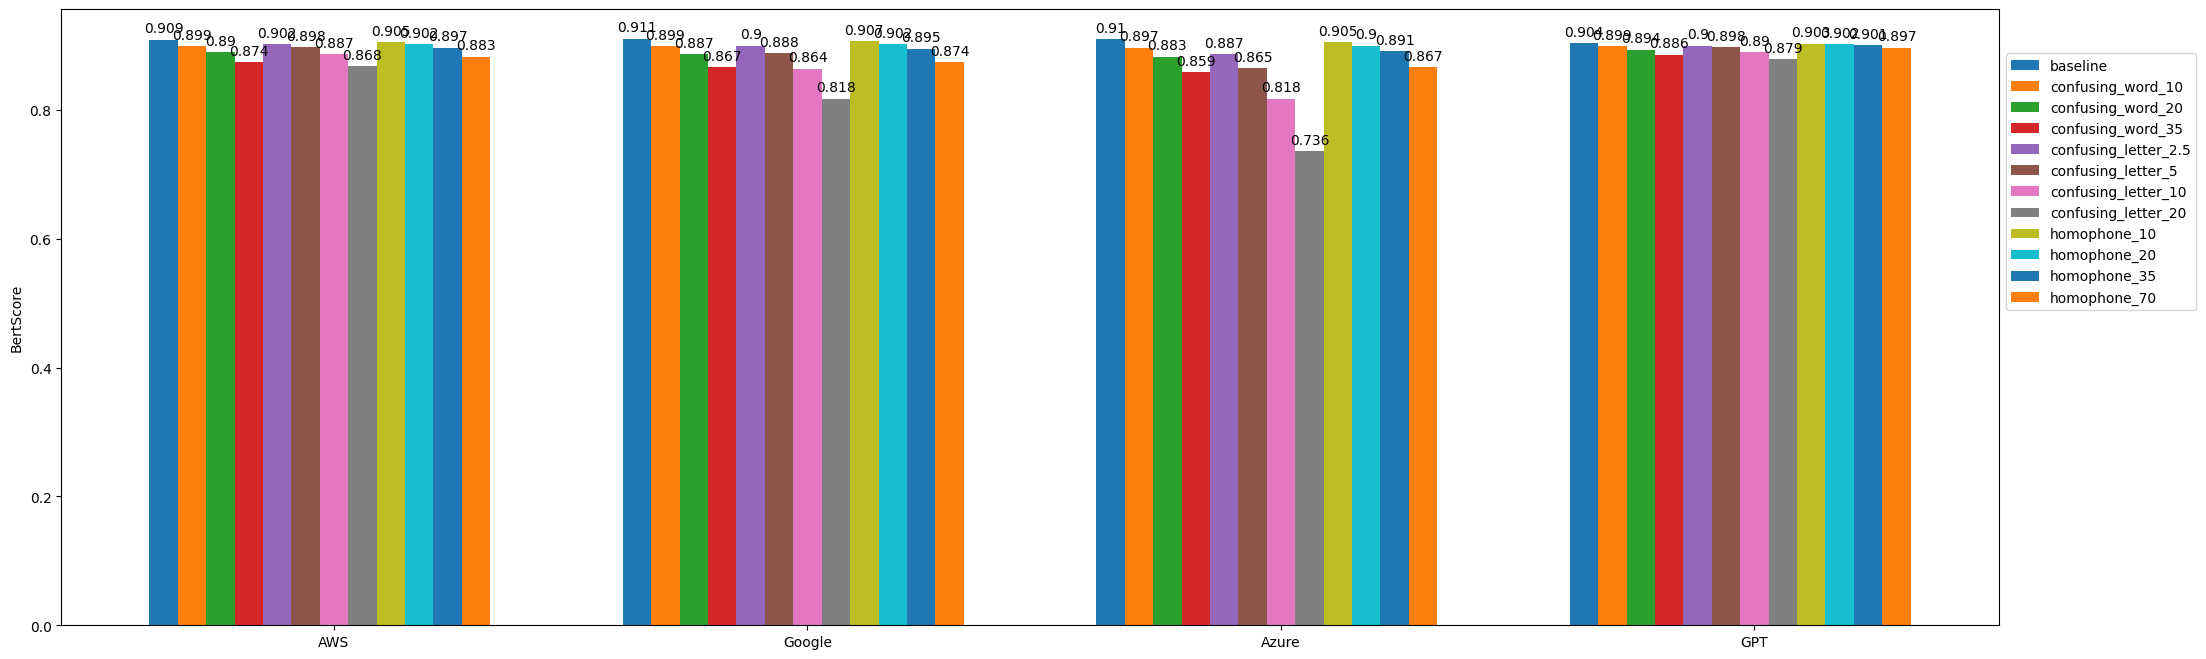

In [11]:
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline_COMET,
    'confusing_word_10': confusing_word_10_COMET[0:-1],
    'confusing_word_20': confusing_word_20_COMET[0:-1],
    'confusing_word_35': confusing_word_35_COMET[0:-1],
    'confusing_letter_2.5': confusing_letter_2_5_COMET[0:-1],
    'confusing_letter_5': confusing_letter_5_COMET[0:-1],
    'confusing_letter_10': confusing_letter_10_COMET[0:-1],
    'confusing_letter_20': confusing_letter_20_COMET[0:-1],
    'homophone_10': homophone_10_COMET[0:-1],
    'homophone_20': homophone_20_COMET[0:-1],
    'homophone_35': homophone_35_COMET[0:-1],
    'homophone_70': homophone_70_COMET[0:-1]
}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('COMET Score')
#ax.set_title('BLEU Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width*6, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


In [32]:
#print SE for COMET scores
print(f"Baseline: AWS: {baseline_COMET_se[0]}, Google: {baseline_COMET_se[1]}, Azure: {baseline_COMET_se[2]}, GPT: {baseline_COMET_se[3]}")
print(f"Confusing Word 10: AWS:{confusing_word_10_COMET_se[0]}, Google:{confusing_word_10_COMET_se[1]}, Azure:{confusing_word_10_COMET_se[2]}, GPT:{confusing_word_10_COMET_se[3]}")
print(f"Confusing Word 20: AWS:{confusing_word_20_COMET_se[0]}, Google:{confusing_word_20_COMET_se[1]}, Azure:{confusing_word_20_COMET_se[2]}, GPT:{confusing_word_20_COMET_se[3]}")
print(f"Confusing Word 35: AWS:{confusing_word_35_COMET_se[0]}, Google:{confusing_word_35_COMET_se[1]}, Azure:{confusing_word_35_COMET_se[2]}, GPT:{confusing_word_35_COMET_se[3]}")
print(f"Confusing Letter 2.5: AWS:{confusing_letter_2_5_COMET_se[0]}, Google:{confusing_letter_2_5_COMET_se[1]}, Azure:{confusing_letter_2_5_COMET_se[2]}, GPT:{confusing_letter_2_5_COMET_se[3]}")
print(f"Confusing Letter 5: AWS:{confusing_letter_5_COMET_se[0]}, Google:{confusing_letter_5_COMET_se[1]}, Azure:{confusing_letter_5_COMET_se[2]}, GPT:{confusing_letter_5_COMET_se[3]}")
print(f"Confusing Letter 10: AWS:{confusing_letter_10_COMET_se[0]}, Google:{confusing_letter_10_COMET_se[1]}, Azure:{confusing_letter_10_COMET_se[2]}, GPT:{confusing_letter_10_COMET_se[3]}")
print(f"Confusing Letter 20: AWS:{confusing_letter_20_COMET_se[0]}, Google:{confusing_letter_20_COMET_se[1]}, Azure:{confusing_letter_20_COMET_se[2]}, GPT:{confusing_letter_20_COMET_se[3]}")
print(f"Homophone 10: AWS:{homophone_10_COMET_se[0]}, Google:{homophone_10_COMET_se[1]}, Azure:{homophone_10_COMET_se[2]}, GPT:{homophone_10_COMET_se[3]}")
print(f"Homophone 20: AWS:{homophone_20_COMET_se[0]}, Google:{homophone_20_COMET_se[1]}, Azure:{homophone_20_COMET_se[2]}, GPT:{homophone_20_COMET_se[3]}")
print(f"Homophone 35: AWS:{homophone_35_COMET_se[0]}, Google:{homophone_35_COMET_se[1]}, Azure:{homophone_35_COMET_se[2]}, GPT:{homophone_35_COMET_se[3]}")
print(f"Homophone 70: AWS:{homophone_70_COMET_se[0]}, Google:{homophone_70_COMET_se[1]}, Azure:{homophone_70_COMET_se[2]}, GPT:{homophone_70_COMET_se[3]}")


Baseline: AWS:0.09019729303439669, Google:0.08879016185937182, Azure:0.08942703331953687, GPT:0.08920354004239338
Confusing Word 10: AWS:0.09330793408775448, Google:0.09481623927375706, Azure:0.09562379133746621, GPT:0.09179805741329623
Confusing Word 20: AWS:0.09798134075798602, Google:0.09843157786102327, Azure:0.10085588734024634, GPT:0.09449775542754457
Confusing Word 35: AWS:0.10396273632680328, Google:0.10676623129568788, Azure:0.10970773579137803, GPT:0.09838161604548873
Confusing Letter 2.5: AWS:0.09220423515353009, Google:0.09220675463819154, Azure:0.09542322735133635, GPT:0.09011559665035582
Confusing Letter 5: AWS:0.09333243995489517, Google:0.09709448366519646, Azure:0.10288281421900883, GPT:0.09014785660457626
Confusing Letter 10: AWS:0.09656244988918258, Google:0.1065674353527631, Azure:0.11916066672911681, GPT:0.09454322572277764
Confusing Letter 20: AWS:0.10257206903049154, Google:0.1349465549089546, Azure:0.13777445276093547, GPT:0.10429998259288231
Homophone 10: AWS:0

### COMET SE

No multiplication by 100 (f1 score ranges from 0-1.0)
- Baseline: AWS:0.000901972930343967, Google:0.0008879016185937182, Azure:0.0008942703331953687, GPT:0.0008920354004239339
- Confusing Word 10: AWS:0.0009330793408775447, Google:0.0009481623927375706, Azure:0.0009562379133746621, GPT:0.0009179805741329624
- Confusing Word 20: AWS:0.0009798134075798602, Google:0.0009843157786102329, Azure:0.0010085588734024633, GPT:0.0009449775542754456
- Confusing Word 35: AWS:0.0010396273632680328, Google:0.0010676623129568788, Azure:0.0010970773579137803, GPT:0.0009838161604548874
- Confusing Letter 2.5: AWS:0.0009220423515353008, Google:0.0009220675463819153, Azure:0.0009542322735133634, GPT:0.0009011559665035582
- Confusing Letter 5: AWS:0.0009333243995489518, Google:0.0009709448366519646, Azure:0.0010288281421900881, GPT:0.0009014785660457626
- Confusing Letter 10: AWS:0.0009656244988918259, Google:0.001065674353527631, Azure:0.001191606667291168, GPT:0.0009454322572277764
- Confusing Letter 20: AWS:0.0010257206903049154, Google:0.001349465549089546, Azure:0.0013777445276093548, GPT:0.001042999825928823
- Homophone 10: AWS:0.0009106913852924412, Google:0.0009062500863420536, Azure:0.0009158370145527441, GPT:0.0008932454829567211
- Homophone 20: AWS:0.0009172637227819139, Google:0.0009156521343532965, Azure:0.000927032774095344, GPT:0.000884152127168615
- Homophone 35: AWS:0.0009582046164410939, Google:0.0009648008798737619, Azure:0.0009887050626326322, GPT:0.0008987137017126878
- Homophone 70: AWS:0.0010111718178014706, Google:0.0010677538058419748, Azure:0.0010928692603361274, GPT:0.0009204908345303176`

F1 scores multiplied by 100 (f1 score ranges from 0-100)
- Baseline: AWS:0.09019729303439669, Google:0.08879016185937182, Azure:0.08942703331953687, GPT:0.08920354004239338
- Confusing Word 10: AWS:0.09330793408775448, Google:0.09481623927375706, Azure:0.09562379133746621, GPT:0.09179805741329623
- Confusing Word 20: AWS:0.09798134075798602, Google:0.09843157786102327, Azure:0.10085588734024634, GPT:0.09449775542754457
- Confusing Word 35: AWS:0.10396273632680328, Google:0.10676623129568788, Azure:0.10970773579137803, GPT:0.09838161604548873
- Confusing Letter 2.5: AWS:0.09220423515353009, Google:0.09220675463819154, Azure:0.09542322735133635, GPT:0.09011559665035582
- Confusing Letter 5: AWS:0.09333243995489517, Google:0.09709448366519646, Azure:0.10288281421900883, GPT:0.09014785660457626
- Confusing Letter 10: AWS:0.09656244988918258, Google:0.1065674353527631, Azure:0.11916066672911681, GPT:0.09454322572277764
- Confusing Letter 20: AWS:0.10257206903049154, Google:0.1349465549089546, Azure:0.13777445276093547, GPT:0.10429998259288231
- Homophone 10: AWS:0.09106913852924413, Google:0.09062500863420538, Azure:0.09158370145527443, GPT:0.08932454829567212
- Homophone 20: AWS:0.09172637227819139, Google:0.09156521343532964, Azure:0.0927032774095344, GPT:0.0884152127168615
- Homophone 35: AWS:0.09582046164410937, Google:0.0964800879873762, Azure:0.09887050626326321, GPT:0.08987137017126878
- Homophone 70: AWS:0.10111718178014706, Google:0.10677538058419749, Azure:0.10928692603361276, GPT:0.09204908345303177

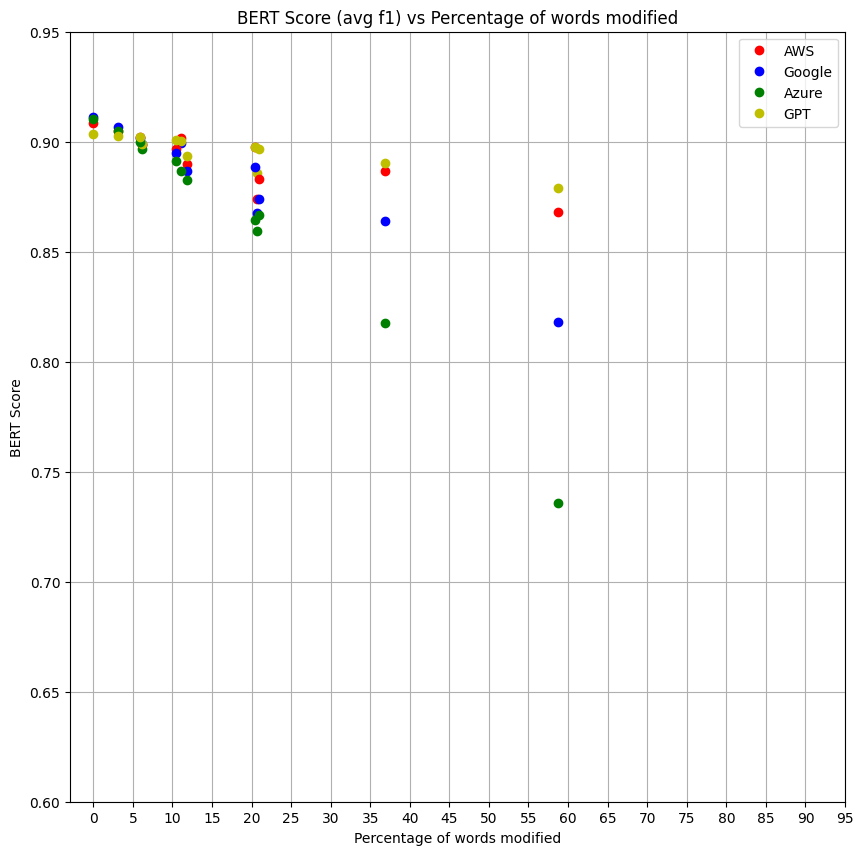

In [21]:
#same as above but for COMET_score
all_data = {
    0: baseline_COMET,
    confusing_word_10_COMET[-1]: confusing_word_10_COMET[0:-1],
    confusing_word_20_COMET[-1]: confusing_word_20_COMET[0:-1],
    confusing_word_35_COMET[-1]: confusing_word_35_COMET[0:-1],
    confusing_letter_2_5_COMET[-1]: confusing_letter_2_5_COMET[0:-1],
    confusing_letter_5_COMET[-1]: confusing_letter_5_COMET[0:-1],
    confusing_letter_10_COMET[-1]: confusing_letter_10_COMET[0:-1],
    confusing_letter_20_COMET[-1]: confusing_letter_20_COMET[0:-1],
    confusing_word_35_COMET[-1]: confusing_word_35_COMET[0:-1],
    homophone_10_COMET[-1]: homophone_10_COMET[0:-1],
    homophone_20_COMET[-1]: homophone_20_COMET[0:-1],
    homophone_35_COMET[-1]: homophone_35_COMET[0:-1],
    homophone_70_COMET[-1]: homophone_70_COMET[0:-1],
}

fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('COMET Score (avg f1) vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('COMET Score')
ax.legend(services)

#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.60, 1.0, 0.05))
ax.set_xticks(np.arange(0, 100, 5))
#show grid
ax.grid(True)
plt.show()



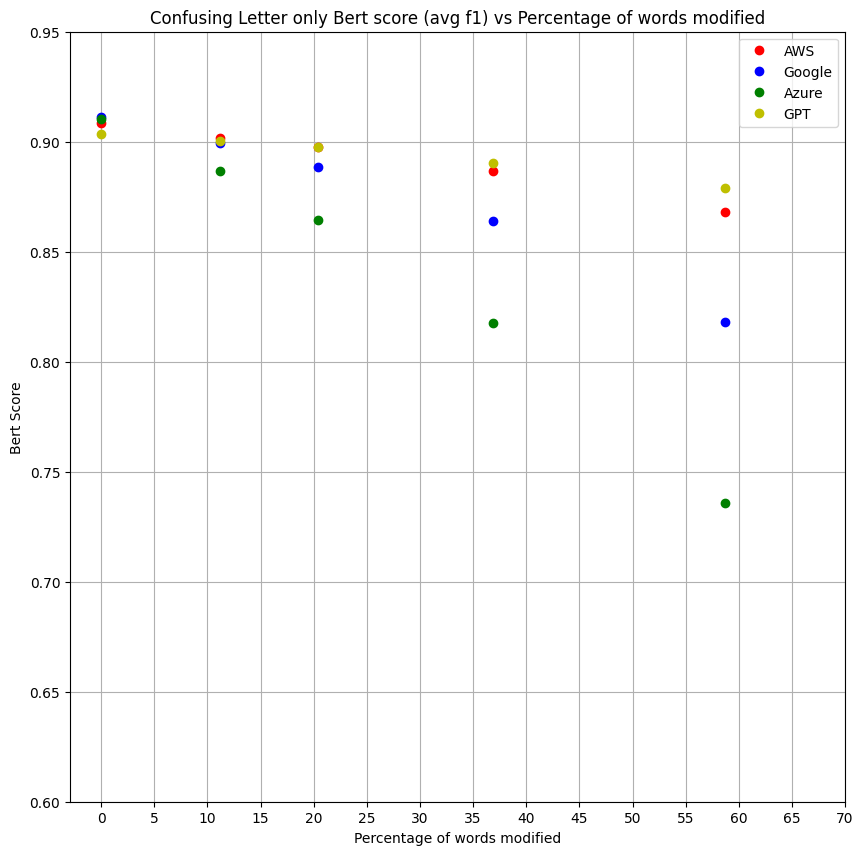

In [22]:
all_data = {
    0: baseline_COMET,
    confusing_letter_2_5_COMET[-1]: confusing_letter_2_5_COMET[0:-1],
    confusing_letter_5_COMET[-1]: confusing_letter_5_COMET[0:-1],
    confusing_letter_10_COMET[-1]: confusing_letter_10_COMET[0:-1],
    confusing_letter_20_COMET[-1]: confusing_letter_20_COMET[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Letter only Bert score (avg f1) vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('COMET Score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.6, 1, 0.05))
ax.set_xticks(np.arange(0, 75, 5))
#show grid
ax.grid(True)
plt.show()

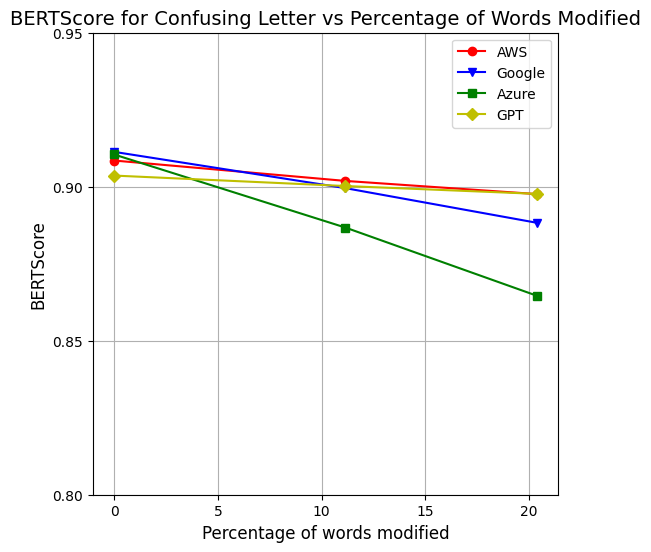

In [40]:
#same as above but for COMET score
all_data_2_confusing_letter = {
    'AWS': [baseline_COMET[0], confusing_letter_2_5_COMET[0], confusing_letter_5_COMET[0]],
    'Google': [baseline_COMET[1], confusing_letter_2_5_COMET[1], confusing_letter_5_COMET[1]],
    'Azure': [baseline_COMET[2], confusing_letter_2_5_COMET[2], confusing_letter_5_COMET[2]],
    'GPT': [baseline_COMET[3], confusing_letter_2_5_COMET[3], confusing_letter_5_COMET[3]]

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_letter_2_5_COMET[-1], confusing_letter_5_COMET[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_letter.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('COMET Score for Confusing Letter vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('COMET Score', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.80, 1, 0.05))
ax.set_xticks(np.arange(0, 21, 5))
#show grid
ax.grid(True)

plt.show()

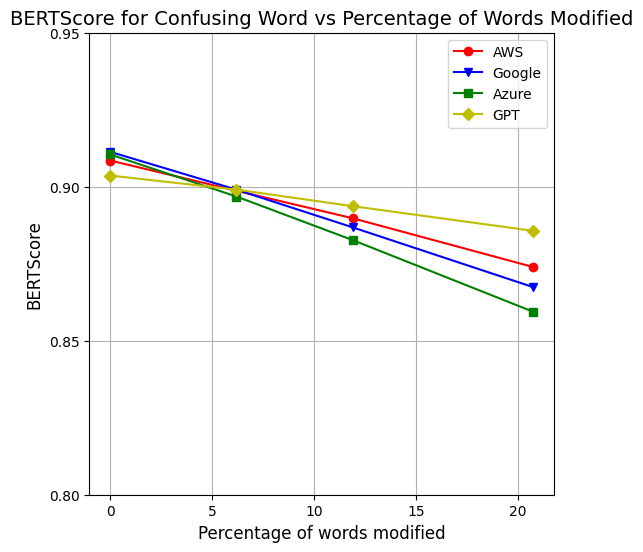

In [41]:
#same as previous but for Confusing word
all_data_2_confusing_word = {
    'AWS': [baseline_COMET[0], confusing_word_10_COMET[0], confusing_word_20_COMET[0], confusing_word_35_COMET[0]],
    'Google': [baseline_COMET[1], confusing_word_10_COMET[1], confusing_word_20_COMET[1], confusing_word_35_COMET[1]],
    'Azure': [baseline_COMET[2], confusing_word_10_COMET[2], confusing_word_20_COMET[2], confusing_word_35_COMET[2]],
    'GPT': [baseline_COMET[3], confusing_word_10_COMET[3], confusing_word_20_COMET[3], confusing_word_35_COMET[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_word_10_COMET[-1], confusing_word_20_COMET[-1], confusing_word_35_COMET[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_word.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('COMET Score for Confusing Word vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('COMET Score', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.80, 1, 0.05))
ax.set_xticks(np.arange(0, 21, 5))
#show grid
ax.grid(True)

plt.show()

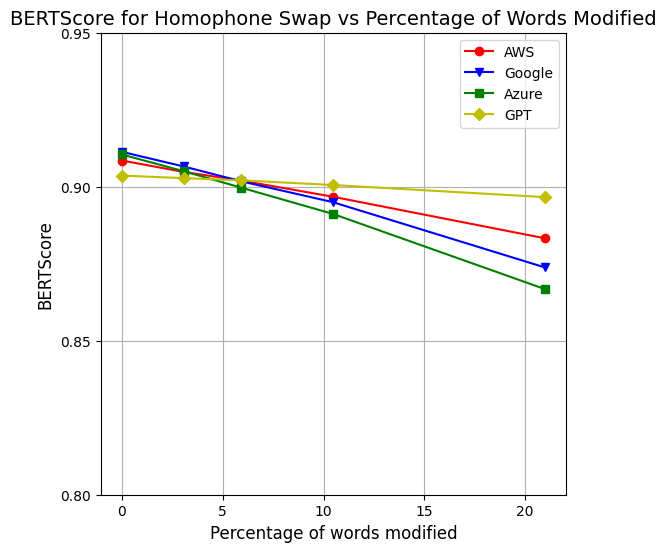

In [45]:
#same for homophone swapping

all_data_2_homophone = {
    'AWS': [baseline_COMET[0], homophone_10_COMET[0], homophone_20_COMET[0], homophone_35_COMET[0], homophone_70_COMET[0]],
    'Google': [baseline_COMET[1], homophone_10_COMET[1], homophone_20_COMET[1], homophone_35_COMET[1], homophone_70_COMET[1]],
    'Azure': [baseline_COMET[2], homophone_10_COMET[2], homophone_20_COMET[2], homophone_35_COMET[2], homophone_70_COMET[2]],
    'GPT': [baseline_COMET[3], homophone_10_COMET[3], homophone_20_COMET[3], homophone_35_COMET[3], homophone_70_COMET[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, homophone_10_COMET[-1], homophone_20_COMET[-1], homophone_35_COMET[-1], homophone_70_COMET[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0

for x, data in all_data_2_homophone.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('COMET Score for Homophone Swap vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('COMET Score', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)

#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.80, 1, 0.05))
ax.set_xticks(np.arange(0, 22, 5))
#show grid
ax.grid(True)
plt.show()

